In [1]:
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jaren/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [115]:
input_file = 'Data/PRSA_data_2010.1.1-2014.12.31.csv'
data = pd.read_csv(input_file, encoding='utf-8')

# Drop rows with missing values
data = data.dropna()

# Convert date and time to datetime
def to_datetime(x):
    date = datetime.datetime(
        year=int(x['year']), 
        month=int(x['month']), 
        day=int(x['day']), 
        hour=int(x['hour'])
    )
    return date

data['time'] = data.apply(to_datetime, axis=1)
data.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
data.set_index('time', inplace=True)

# Convert wind direction to one-hot encoding
data = data.join(pd.get_dummies(data['cbwd']))
del data['cbwd']

history_length = 24 * 8 # Use previous 8 days of data to predict
delay = 24 * 1 # Predict 1 day ahead

# Create a numpy array of shape (samples, history_length + delay, features)
num_samples = len(data) - history_length - delay

history_data = np.zeros((num_samples, history_length + delay, data.shape[-1]))

for i in range(num_samples):
    history_data[i] = data.iloc[i : i + history_length + delay]
    
data = np.array(history_data)

print(data.shape)



(41541, 216, 11)


In [117]:
X = data[:, :history_length, :]
y = data[:, -1, 0] # PM2.5 is the first column

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_X = torch.tensor(train_X, dtype=torch.float32)
test_X  = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_y  = torch.tensor(test_y, dtype=torch.float32)

In [94]:
torch.manual_seed(123456789)

class FFNetwork(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.5):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, l1_features := 64),
            nn.ReLU(),
            nn.Linear(l1_features, out_features),
        )


    def forward(self, x):
        output = self.l1(x)
        return output

In [122]:
regressor_ff = NeuralNetRegressor(
    # Module
    module=FFNetwork,
    module__in_features=data.shape[-1] * history_length,
    module__out_features=1,
    # Criterion
    criterion=nn.MSELoss,
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.002,
    lr=0.01,
    # Training
    max_epochs=50,
    batch_size=256,
    # Misc
    verbose=1,
    device=device,
)



train_y = train_y.reshape(-1, 1)

print(train_X.shape)
print(train_y.shape)

regressor_ff.fit(train_X, train_y)
prediction_probs = regressor_ff.predict(test_X)



torch.Size([33232, 192, 11])
torch.Size([33232, 1])
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   231705.0183     7669.8140  0.4159
      2     8236.9749     7375.7259  0.4585
      3     7965.9853     7110.6001  0.4086
      4     7750.1841     6930.9958  0.3997
      5     7593.6684     6821.5758  0.3955
      6     7487.4060     6654.4700  0.4122
      7     7394.2232     6578.3638  0.3824
      8     7343.4268     6529.6683  0.4233
      9     7318.9383     6516.6227  0.3984
     10     7295.1885     6612.2001  0.3958
     11     7284.3406     6597.4822  0.4648
     12     7278.3414     6529.2699  0.3935
     13     7269.3512     6467.5834  0.3968
     14     7255.1295     6431.6479  0.3912
     15     7242.6375     6415.5909  0.3905
     16     7236.8185     6407.2267  0.4286
     17     7235.4347     6401.2641  0.4018
     18     7234.1469     6396.6741  0.3973
     19     7231.2536     6392.7927  0.4038
     20     7227.0841   

Loss: 61.02


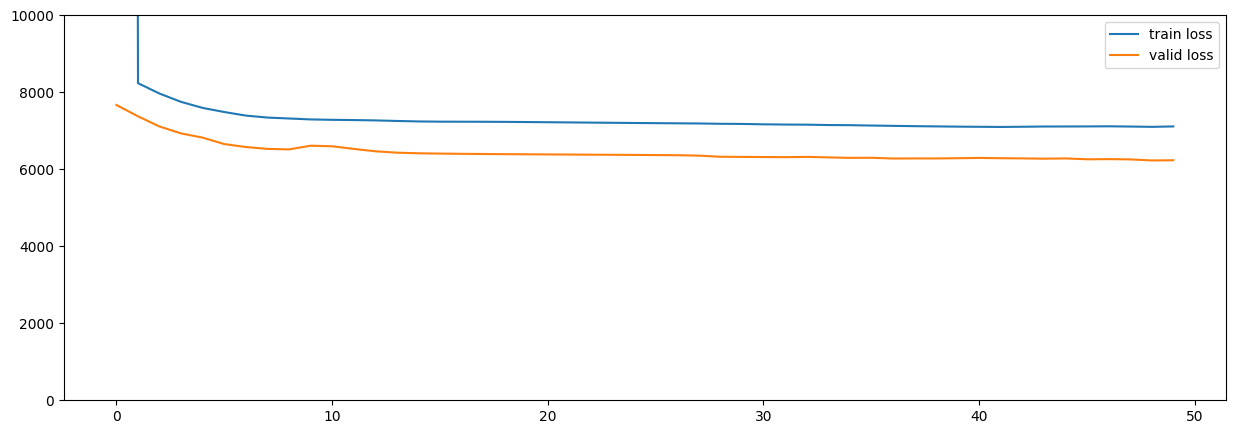

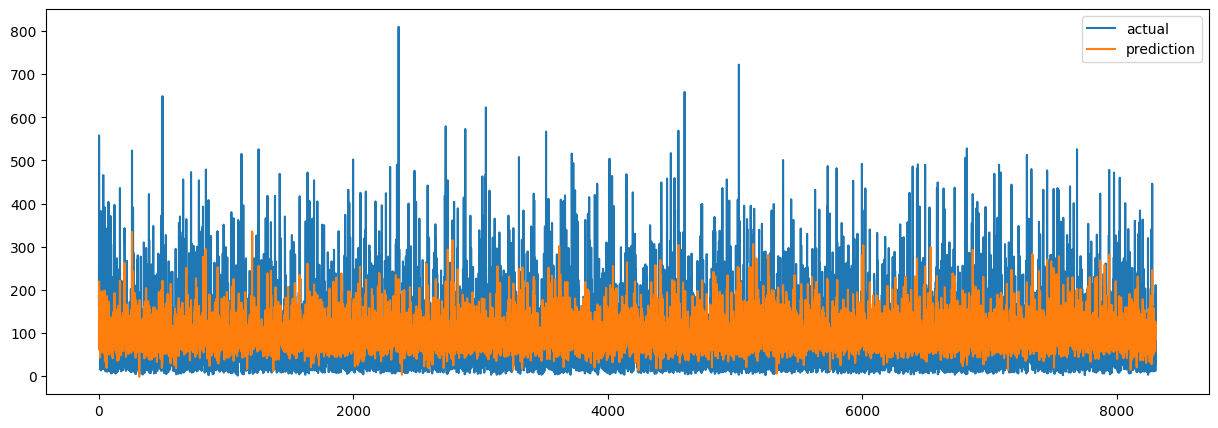

In [133]:
loss = nn.functional.l1_loss(torch.tensor(prediction_probs).reshape(-1), test_y).item()
print(f"Loss: {loss:.2f}")

plt.figure(figsize=(15, 5))
plt.plot(regressor_ff.history[:, 'train_loss'], label='train loss')
plt.plot(regressor_ff.history[:, 'valid_loss'], label='valid loss')
plt.ylim(0, 10000)
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(test_y, label='actual')
plt.plot(prediction_probs, label='prediction')
plt.legend()
plt.show()



In [130]:
class LSTMNetwork(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.5, history_length: int = 24 * 8):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=64,
            num_layers=3,
            dropout=dropout,
            batch_first=True,
        )

        self.l2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*history_length, out_features),
            nn.ReLU()
        )
        


    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        output = self.l2(output)
        
        return output

In [131]:
regressor_lstm = NeuralNetRegressor(
    # Module
    module=LSTMNetwork,
    module__in_features=11,
    module__out_features=1,
    module__dropout=0.15,
    module__history_length=history_length,
    # Criterion
    criterion=nn.MSELoss,
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.01,
    lr=0.001,
    # Training
    max_epochs=150,
    batch_size=256,
    # Misc
    verbose=1,
    device=device,
    callbacks=[
        EarlyStopping(patience=10),
    ]
)



train_y = train_y.reshape(-1, 1)

print(train_X.shape)
print(train_y.shape)

regressor_lstm.fit(train_X, train_y)
prediction_probs_lstm = regressor_lstm.predict(test_X)



torch.Size([33232, 192, 11])
torch.Size([33232, 1])
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     9601.9038     7948.4524  1.3989
      2     8579.6940     7745.2256  1.3660
      3     8279.9159     7335.6120  1.3631
      4     7876.8862     6941.1520  1.4010
      5     7602.0885     6686.9588  1.3562
      6     7412.8679     6523.7790  1.3829
      7     7286.8780     6546.7781  1.4421
      8     7193.3112     6359.4497  1.3723
      9     7092.1632     6289.4943  1.4178
     10     7004.0024     6291.2991  1.3708
     11     6964.9494     6175.9752  1.3817
     12     6866.5750     6187.0081  1.3961
     13     6751.4592     6133.7577  1.3703
     14     6782.2960     6048.5844  1.3741
     15     6735.2015     6107.2820  1.3838
     16     6561.3763     6005.1635  1.4303
     17     6509.3455     5834.6562  1.3925
     18     6378.0570     5712.9876  1.4104
     19     6127.6356     5682.3789  1.3742
     20     6001.2102   

Loss: 21.47


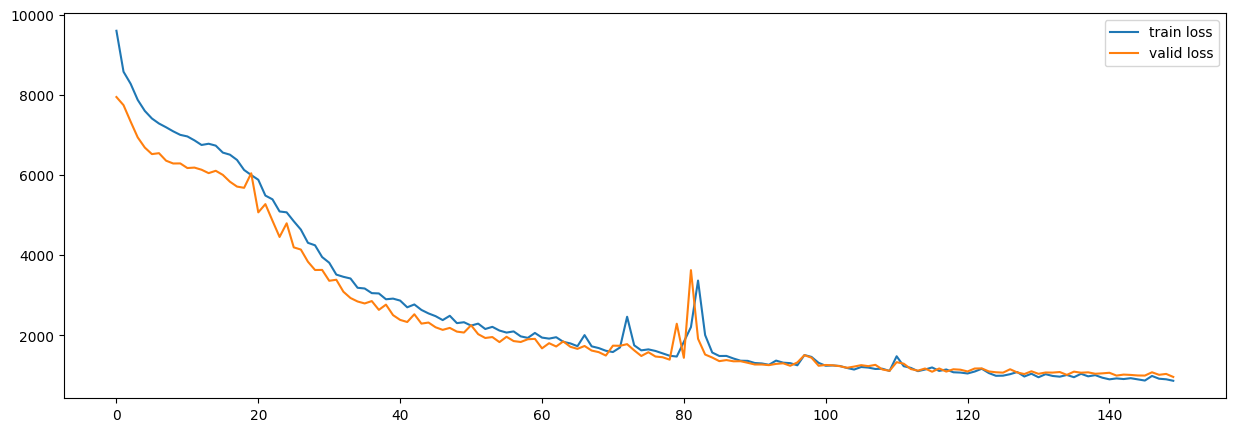

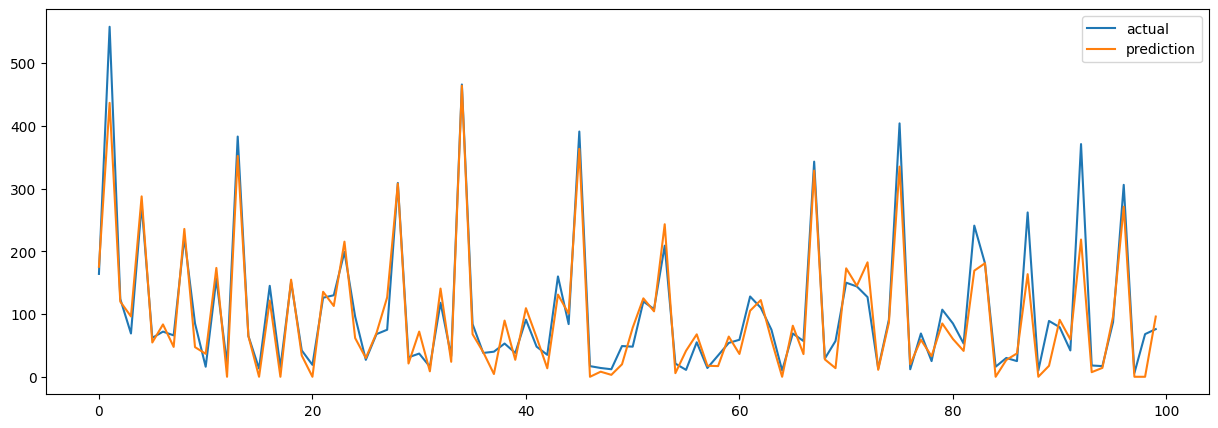

In [137]:
loss = nn.functional.l1_loss(torch.tensor(prediction_probs_lstm).reshape(-1), test_y).item()
print(f"Loss: {loss:.2f}")


plt.figure(figsize=(15, 5))
plt.plot(regressor_lstm.history[:, 'train_loss'], label='train loss')
plt.plot(regressor_lstm.history[:, 'valid_loss'], label='valid loss')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
to_show = 100
plt.plot(test_y[:to_show], label='actual')
plt.plot(prediction_probs_lstm[:to_show], label='prediction')
plt.legend()
plt.show()

